In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import polars as pl
import toml
from support import preprocess

In [2]:
_base_pth = toml.load("data_path.toml")['files']['pth']
_folder_name = 'normal_ss_t1'

_data_pth = os.path.join(_base_pth, _folder_name)

_mobbo_base_names = [
    'mobbo1.csv',
    'mobbo2.csv',
    'mobbo3.csv',
    'mobbo4.csv',
    'mobbo5.csv',
    'mobbo6.csv',
                     ]

In [3]:
dfs = {'m1':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[0])),
       'm2':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[1])),
       'm3':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[2])),
       'm4':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[3])),
       'm5':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[4])),
       'm6':pl.read_csv(os.path.join(_data_pth, _mobbo_base_names[5]))}

## Changing polarity for two boards m5 and m6

In [4]:
dfs['m5'] = dfs['m5'].with_columns([(pl.col('f1')*-1).alias('f1'),
                                    (pl.col('f2')*-1).alias('f2'),
                                    (pl.col('f3')*-1).alias('f3'),
                                    (pl.col('f4')*-1).alias('f4'),])

dfs['m6'] = dfs['m6'].with_columns([(pl.col('f1')*-1).alias('f1'),
                                    (pl.col('f2')*-1).alias('f2'),
                                    (pl.col('f3')*-1).alias('f3'),
                                    (pl.col('f4')*-1).alias('f4'),])

## Pre processing files

In [5]:
dfs = preprocess(dfs)

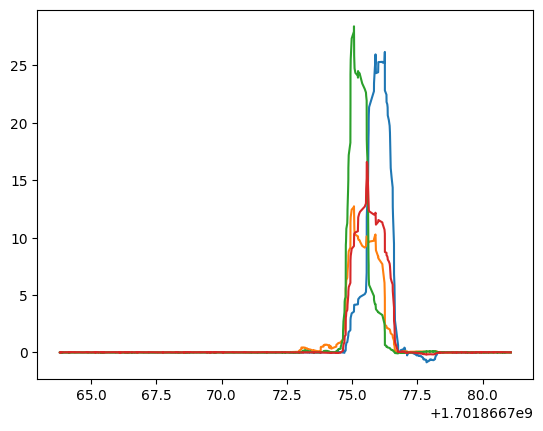

In [6]:
plt.plot(dfs['m5']['timestamp'], dfs['m5']['f1'], label='f1')
plt.plot(dfs['m5']['timestamp'], dfs['m5']['f2'], label='f2')
plt.plot(dfs['m5']['timestamp'], dfs['m5']['f3'], label='f3')
plt.plot(dfs['m5']['timestamp'], dfs['m5']['f4'], label='f4')

## Calculating local COP

In [7]:
for _df_name in dfs.keys():
    _temp_df = dfs[_df_name]
    cop_x = []
    cop_y = []
    for i in range(len(dfs[_df_name]['timestamp'])):
        
        _weight = _temp_df['f1'][i] + _temp_df['f2'][i] + _temp_df['f3'][i] + _temp_df['f4'][i]
        if _weight>2:
            cop_x.append((((_temp_df['f1'][i]+_temp_df['f4'][i])-(_temp_df['f2'][i]+_temp_df['f3'][i]))*30/_weight))
            cop_y.append((((_temp_df['f3'][i]+_temp_df['f4'][i])-(_temp_df['f1'][i]+_temp_df['f2'][i]))*22.5/_weight))
        else:
            cop_x.append(np.nan)
            cop_y.append(np.nan)
        
    cop_x = pl.Series('cop_x',cop_x)
    cop_y = pl.Series('cop_y',cop_y)
    _temp_df.insert_column(-1, cop_x)
    _temp_df.insert_column(-1, cop_y)
    dfs[_df_name] = _temp_df

## Local COP plot for all boards

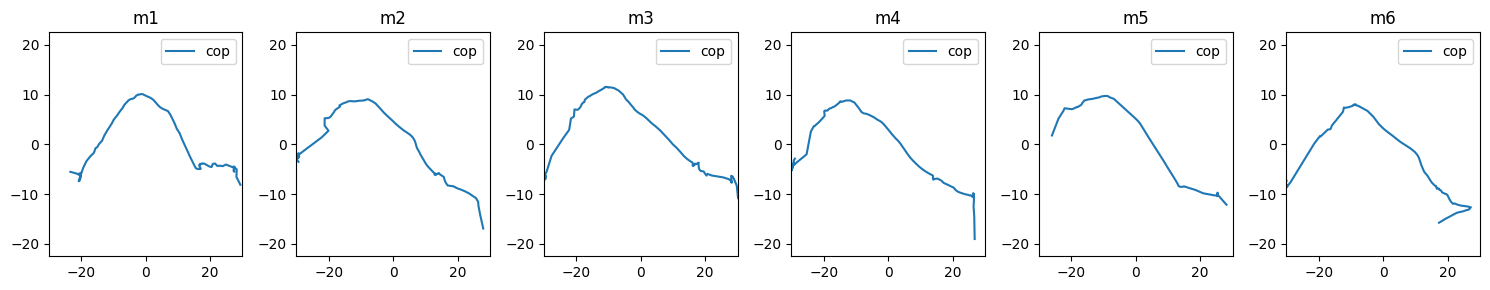

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))

# Plotting the data on each subplot
for i, df_name in enumerate(dfs.keys()):
    axes[i].plot(dfs[df_name]['cop_x'], dfs[df_name]['cop_y'], label='cop')
    axes[i].set_title(df_name)
    axes[i].set_xlim(-30, 30)
    axes[i].set_ylim(-22.5, 22.5)
    axes[i].legend()
plt.tight_layout()
plt.show()


## Calculating global COP